Ref: https://www.youtube.com/watch?v=m1G7oS9hmwE

In [1]:
# same libs
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 2.9 MB/s 
     |████████████████████████████████| 3.5 MB 3.0 MB/s 


edge prediction：Between node A & node B，find out if there's a connection(edge) 

In [2]:
import os.path as osp

import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

import torch_geometric
from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

In [3]:
# use cpu if has
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

In [4]:
# load the Cora dataset
# Cora dataset is well-known for graph learning
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]
print(dataset.data)

Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


In [5]:
# check a sample
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [6]:
# use train_test_split_edges to create neg and positive edges
# initilize our own mask (mask is just training/testing/validation dasta)
data.train_mask = data.val_mask = data.test_mask = data.y = None
# initilize our own mask
data = train_test_split_edges(data)
print(data)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[2708, 1433], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])


In [7]:
# Simple autoencoder model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 128)
        self.conv2 = GCNConv(128, 64)

    def encode(self):
        x = self.conv1(data.x, data.train_pos_edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, data.train_pos_edge_index) # convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        # concatenate pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) 
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        # get predicted edge_list
        return (prob_adj > 0).nonzero(as_tuple=False).t()      

In [8]:
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [9]:
def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

In [10]:
def train():
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()
    
    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs

In [12]:
best_val_perf = test_perf = 0
for epoch in range(1, 101):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf))

Epoch: 010, Loss: 0.5697, Val: 0.7591, Test: 0.7949
Epoch: 020, Loss: 0.5176, Val: 0.8107, Test: 0.8578
Epoch: 030, Loss: 0.4794, Val: 0.8583, Test: 0.8839
Epoch: 040, Loss: 0.4718, Val: 0.8670, Test: 0.8837
Epoch: 050, Loss: 0.4571, Val: 0.8810, Test: 0.8919
Epoch: 060, Loss: 0.4514, Val: 0.8841, Test: 0.8945
Epoch: 070, Loss: 0.4525, Val: 0.8841, Test: 0.8945
Epoch: 080, Loss: 0.4460, Val: 0.8841, Test: 0.8945
Epoch: 090, Loss: 0.4432, Val: 0.8841, Test: 0.8945
Epoch: 100, Loss: 0.4345, Val: 0.8869, Test: 0.9028


In [13]:
z = model.encode()
final_edge_index = model.decode_all(z)

In [14]:
final_edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [   0,    2,    4,  ..., 2705, 2706, 2707]])

-----

Edge Label Prediction：predict两个nodes之间的edge的lebel(features)

In [15]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
from torch_geometric.datasets import TUDataset

import numpy as np

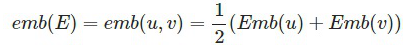

**Node2Vec**：convert two nodes to embeddings, and then take its average

In [16]:
# use gpu is has
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
dataset = "AIDS"
data = TUDataset(".", name=dataset)

Extracting ./AIDS/AIDS.zip
Processing...
Done!


In [17]:
print(data)
print("number of classes: ",data.num_classes,"\t\t(active),(inactive)")
print("number of features: ",data.num_features)
print("number of edge labels: ",data.num_edge_labels)
# this dataset is molecule

AIDS(2000)
number of classes:  2 		(active),(inactive)
number of features:  38
number of edge labels:  3


In [18]:
#selecet a sample
data1 = data[1]

# extract edge list
edge_list = data1.edge_index.t().numpy()
print(edge_list[0:10])
#show 10 edges

[[0 1]
 [0 5]
 [1 0]
 [1 2]
 [1 6]
 [2 1]
 [2 3]
 [3 2]
 [3 4]
 [3 7]]


In [19]:
# extract edge attributes
edge_attr = data1.edge_attr.numpy()
print(edge_attr[0:10])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [20]:
# use Networkx for plot a graph
import networkx as nx

# build the graph
graph1 = nx.Graph()

for i in range(len(edge_list)):
    u = edge_list[i][0]
    v = edge_list[i][1]
    graph1.add_edge(u,v,label=edge_attr[i])
    
print(graph1.edges(data=True))

[(0, 1, {'label': array([1., 0., 0.], dtype=float32)}), (0, 5, {'label': array([1., 0., 0.], dtype=float32)}), (1, 2, {'label': array([1., 0., 0.], dtype=float32)}), (1, 6, {'label': array([0., 1., 0.], dtype=float32)}), (5, 4, {'label': array([1., 0., 0.], dtype=float32)}), (5, 8, {'label': array([1., 0., 0.], dtype=float32)}), (2, 3, {'label': array([1., 0., 0.], dtype=float32)}), (3, 4, {'label': array([1., 0., 0.], dtype=float32)}), (3, 7, {'label': array([0., 1., 0.], dtype=float32)}), (4, 9, {'label': array([1., 0., 0.], dtype=float32)}), (4, 10, {'label': array([1., 0., 0.], dtype=float32)})]


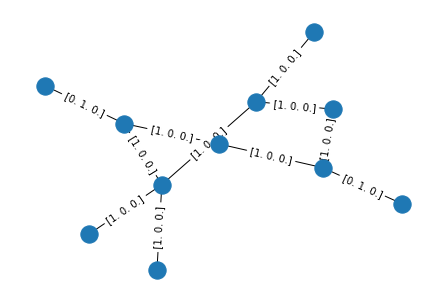

In [21]:
pos = nx.spring_layout(graph1)
nx.draw(graph1,pos)
nx.draw_networkx_edge_labels(graph1,pos,nx.get_edge_attributes(graph1,'label'))
plt.show()

Use only one moleculas compound

In [22]:
data.data

Data(x=[31385, 38], edge_index=[2, 64780], edge_attr=[64780, 3], y=[2000])

In [23]:
data = data[10]
data

Data(edge_index=[2, 166], x=[77, 38], edge_attr=[166, 3], y=[1])

build the graph with train_mask, test_mask, val_mask

In [24]:
np.random.seed(10)
# get the nodes
nodes = data.edge_index.t().numpy()
nodes = np.unique(list(nodes[:,0]) + list(nodes[:,1]))

np.random.shuffle(nodes) # shuffle node order
print(len(nodes))

76


In [25]:
# get train test and val sizes: (70% - 15% - 15%)
train_size = int(len(nodes)*0.7)
test_size = int(len(nodes)*0.85) - train_size
val_size = len(nodes) - train_size - test_size

In [26]:
# get train test and validation set of nodes
train_set = nodes[0:train_size]
test_set = nodes[train_size:train_size+test_size]
val_set = nodes[train_size+test_size:]


print(len(train_set),len(test_set),len(val_set))
print(len(train_set)+len(test_set)+len(val_set) == len(nodes))

print("train set\t",train_set[:10])
print("test set \t",test_set[:10])
print("val set  \t",val_set[:10])

53 11 12
True
train set	 [68 26 21  3 44 41  6 20  2 60]
test set 	 [13 73 51 49 14 67 70 33 58 43]
val set  	 [54 11 16 36 40  0  8 29 28 64]


output we can see: train set、test set、val set (53、11、12)

In [27]:
# build test train val masks

train_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in train_set:
    train_mask[i] = 1.

test_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in test_set:
    test_mask[i] = 1.
    
val_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in val_set:
    val_mask[i] = 1.
    
print("train mask \t",train_mask[0:15])
print("test mask  \t",test_mask[0:15])
print("val mask   \t",val_mask[0:15]) 

train mask 	 tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0])
test mask  	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])
val mask   	 tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0])


In [28]:
# remove from the data what do we not use.

print("befor\t\t",data)
data.x = None
data.edge_attr = None
data.y = None

befor		 Data(edge_index=[2, 166], x=[77, 38], edge_attr=[166, 3], y=[1])


In [29]:
# add masks
data.train_mask = train_mask
data.test_mask = test_mask
data.val_mask = val_mask

print("after\t\t",data)

after		 Data(edge_index=[2, 166], train_mask=[76], test_mask=[76], val_mask=[76])


Use Node2Vec

In [32]:
!pip install torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 2.9 MB/s 


Since I got error directly importing Node2Vec, I copied its implementation from the source instead, so I can used Node2Vec.

In [39]:
# from: https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/node2vec.html
from typing import Optional, Tuple

import torch
from torch import Tensor
from torch.nn import Embedding
from torch.utils.data import DataLoader
from torch_sparse import SparseTensor

from torch_geometric.typing import OptTensor
from torch_geometric.utils.num_nodes import maybe_num_nodes

try:
    import torch_cluster  # noqa
    random_walk = torch.ops.torch_cluster.random_walk
except ImportError:
    random_walk = None

EPS = 1e-15


class Node2Vec(torch.nn.Module):
    r"""The Node2Vec model from the
    `"node2vec: Scalable Feature Learning for Networks"
    <https://arxiv.org/abs/1607.00653>`_ paper where random walks of
    length :obj:`walk_length` are sampled in a given graph, and node embeddings
    are learned via negative sampling optimization.

    .. note::

        For an example of using Node2Vec, see `examples/node2vec.py
        <https://github.com/pyg-team/pytorch_geometric/blob/master/examples/
        node2vec.py>`_.

    Args:
        edge_index (LongTensor): The edge indices.
        embedding_dim (int): The size of each embedding vector.
        walk_length (int): The walk length.
        context_size (int): The actual context size which is considered for
            positive samples. This parameter increases the effective sampling
            rate by reusing samples across different source nodes.
        walks_per_node (int, optional): The number of walks to sample for each
            node. (default: :obj:`1`)
        p (float, optional): Likelihood of immediately revisiting a node in the
            walk. (default: :obj:`1`)
        q (float, optional): Control parameter to interpolate between
            breadth-first strategy and depth-first strategy (default: :obj:`1`)
        num_negative_samples (int, optional): The number of negative samples to
            use for each positive sample. (default: :obj:`1`)
        num_nodes (int, optional): The number of nodes. (default: :obj:`None`)
        sparse (bool, optional): If set to :obj:`True`, gradients w.r.t. to the
            weight matrix will be sparse. (default: :obj:`False`)
    """
    def __init__(
        self,
        edge_index: Tensor,
        embedding_dim: int,
        walk_length: int,
        context_size: int,
        walks_per_node: int = 1,
        p: float = 1.0,
        q: float = 1.0,
        num_negative_samples: int = 1,
        num_nodes: Optional[int] = None,
        sparse: bool = False,
    ):
        super().__init__()

        if random_walk is None:
            raise ImportError('`Node2Vec` requires `torch-cluster`.')

        N = maybe_num_nodes(edge_index, num_nodes)
        row, col = edge_index
        self.adj = SparseTensor(row=row, col=col, sparse_sizes=(N, N))
        self.adj = self.adj.to('cpu')

        assert walk_length >= context_size

        self.embedding_dim = embedding_dim
        self.walk_length = walk_length - 1
        self.context_size = context_size
        self.walks_per_node = walks_per_node
        self.p = p
        self.q = q
        self.num_negative_samples = num_negative_samples

        self.embedding = Embedding(N, embedding_dim, sparse=sparse)

        self.reset_parameters()

    def reset_parameters(self):
        self.embedding.reset_parameters()


    def forward(self, batch: OptTensor = None) -> Tensor:
        """Returns the embeddings for the nodes in :obj:`batch`."""
        emb = self.embedding.weight
        return emb if batch is None else emb.index_select(0, batch)


    def loader(self, **kwargs) -> DataLoader:
        return DataLoader(range(self.adj.sparse_size(0)),
                          collate_fn=self.sample, **kwargs)


    def pos_sample(self, batch: Tensor) -> Tensor:
        batch = batch.repeat(self.walks_per_node)
        rowptr, col, _ = self.adj.csr()
        rw = random_walk(rowptr, col, batch, self.walk_length, self.p, self.q)
        if not isinstance(rw, Tensor):
            rw = rw[0]

        walks = []
        num_walks_per_rw = 1 + self.walk_length + 1 - self.context_size
        for j in range(num_walks_per_rw):
            walks.append(rw[:, j:j + self.context_size])
        return torch.cat(walks, dim=0)


    def neg_sample(self, batch: Tensor) -> Tensor:
        batch = batch.repeat(self.walks_per_node * self.num_negative_samples)

        rw = torch.randint(self.adj.sparse_size(0),
                           (batch.size(0), self.walk_length))
        rw = torch.cat([batch.view(-1, 1), rw], dim=-1)

        walks = []
        num_walks_per_rw = 1 + self.walk_length + 1 - self.context_size
        for j in range(num_walks_per_rw):
            walks.append(rw[:, j:j + self.context_size])
        return torch.cat(walks, dim=0)


    def sample(self, batch: Tensor) -> Tuple[Tensor, Tensor]:
        if not isinstance(batch, Tensor):
            batch = torch.tensor(batch)
        return self.pos_sample(batch), self.neg_sample(batch)


    def loss(self, pos_rw: Tensor, neg_rw: Tensor) -> Tensor:
        r"""Computes the loss given positive and negative random walks."""

        # Positive loss.
        start, rest = pos_rw[:, 0], pos_rw[:, 1:].contiguous()

        h_start = self.embedding(start).view(pos_rw.size(0), 1,
                                             self.embedding_dim)
        h_rest = self.embedding(rest.view(-1)).view(pos_rw.size(0), -1,
                                                    self.embedding_dim)

        out = (h_start * h_rest).sum(dim=-1).view(-1)
        pos_loss = -torch.log(torch.sigmoid(out) + EPS).mean()

        # Negative loss.
        start, rest = neg_rw[:, 0], neg_rw[:, 1:].contiguous()

        h_start = self.embedding(start).view(neg_rw.size(0), 1,
                                             self.embedding_dim)
        h_rest = self.embedding(rest.view(-1)).view(neg_rw.size(0), -1,
                                                    self.embedding_dim)

        out = (h_start * h_rest).sum(dim=-1).view(-1)
        neg_loss = -torch.log(1 - torch.sigmoid(out) + EPS).mean()

        return pos_loss + neg_loss


    def test(
        self,
        train_z: Tensor,
        train_y: Tensor,
        test_z: Tensor,
        test_y: Tensor,
        solver: str = 'lbfgs',
        multi_class: str = 'auto',
        *args,
        **kwargs,
    ) -> float:
        r"""Evaluates latent space quality via a logistic regression downstream
        task."""
        from sklearn.linear_model import LogisticRegression

        clf = LogisticRegression(solver=solver, multi_class=multi_class, *args,
                                 **kwargs).fit(train_z.detach().cpu().numpy(),
                                               train_y.detach().cpu().numpy())
        return clf.score(test_z.detach().cpu().numpy(),
                         test_y.detach().cpu().numpy())


    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.embedding.weight.size(0)}, '
                f'{self.embedding.weight.size(1)})')

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
             context_size=10, walks_per_node=10,
             num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [41]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=10)
    return acc

In [43]:
for epoch in range(1, 101):
    loss = train()
    #acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 10, Loss: 4.2916
Epoch: 20, Loss: 3.7579
Epoch: 30, Loss: 3.2600
Epoch: 40, Loss: 3.0457
Epoch: 50, Loss: 2.9048
Epoch: 60, Loss: 2.7855
Epoch: 70, Loss: 2.7008
Epoch: 80, Loss: 2.6836
Epoch: 90, Loss: 2.6701
Epoch: 100, Loss: 2.6114


In [44]:
z = model()

visualize node embedding

In [45]:
# from tensor to numpy
emb_128 = z.detach().cpu().numpy()

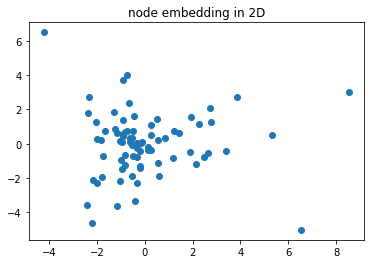

In [46]:
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2) # it used for dimension reduction
emb2d = pca.fit_transform(emb_128)


plt.title("node embedding in 2D")
plt.scatter(emb2d[:,0],emb2d[:,1])
plt.show()

Compute edge embedding

In [48]:
# reload AIDS dataset 
# and pick the same graph


dataset = "AIDS"
data = TUDataset(".", name=dataset)
data = data[10]

In [49]:
# convert edge attributes from categorical to numerical
edge_attr_cat = data.edge_attr.numpy()
print("Categorical edge attributes:\n",edge_attr_cat[:3])

edge_attr = []
for i in edge_attr_cat:
    edge_attr.append(np.nonzero(i)[0][0])

print("\n\nNumerical edge attributes:\n",edge_attr[:3])

Categorical edge attributes:
 [[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


Numerical edge attributes:
 [0, 0, 1]


In [50]:
# compute edge embedding

edge_embedding = []
for u,v in data.edge_index.t():
    edge_embedding.append(np.mean([emb_128[u],emb_128[v]],0))

visualize edge embedding

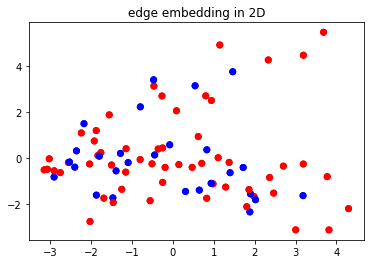

In [51]:
import pandas as pd
# fit and transform using PCA
pca = PCA(n_components=2)
edge_emb2d = pca.fit_transform(edge_embedding)



df = pd.DataFrame(dict(edge_att=edge_attr))
colors = {0:"red",1:"blue"}
plt.title("edge embedding in 2D")
plt.scatter(edge_emb2d[:,0],edge_emb2d[:,1],c=df.edge_att.map(colors))
plt.show()

# not so good but we are using PCA to reduce the dim from 128 to 2

Use RandomForestClassifier with 10-fold cross validation

In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [53]:
clf = RandomForestClassifier(max_depth=7,random_state=10)


scores = cross_val_score(clf, edge_embedding, edge_attr, cv=10)
np.mean(scores)

0.7227941176470588

As the result, by using random forest classifier, we can score of 0.72